In [ ]:
import random, numpy as np, torch
seed = 42
random.seed(seed); np.random.seed(seed)
torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
RUN_NAME = "ae_mse_baseline_bs64_sr8k_T4000"

In [1]:
import sys
import os, glob, random, json
import numpy as np
import matplotlib.pyplot as plt
import librosa

!pip -q install soundfile librosa

import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "no gpu")

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm  # 用纯文本 tqdm，避免 ipywidgets warning


In [2]:
DATA_ROOT = r"C:\Users\11604\Desktop\thesis\hapticgen-dataset\uservoted"  # ← 改这里

wav_files = glob.glob(os.path.join(DATA_ROOT, "**/*.wav"), recursive=True)
print("Found wav:", len(wav_files))

assert len(wav_files) > 0, "没找到任何 wav：请检查 DATA_ROOT 是否指向正确的根目录"


Found wav: 3229


C:\Users\11604\anaconda3\envs\haptics-ae\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



--- I_m_opening_a_can_of_soda_6BCY1_modelB_4.wav
sr: 8000 len: 80000 min/max: -0.3046875 0.3046875


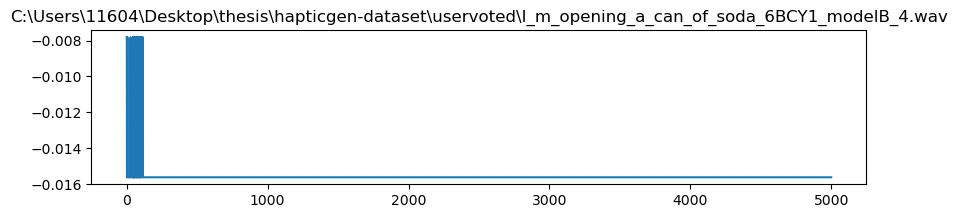


--- Nervousness_as_the_thesis_submission_is_just_aroun_S91P2D_modelA_4.wav
sr: 8000 len: 80000 min/max: -0.3046875 0.3046875


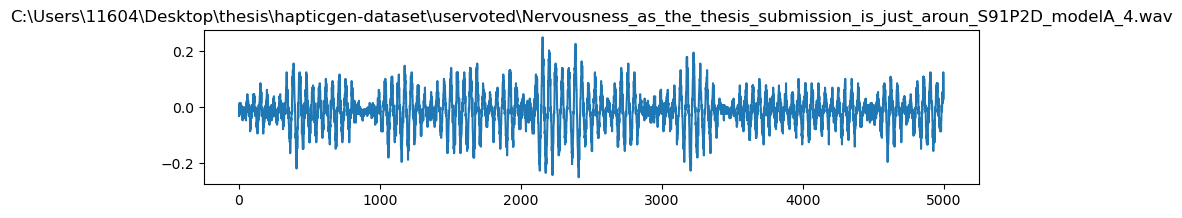


--- Please_express_the_moment_of_teleporting_from_one__WZIZW1_modelA_5.wav
sr: 8000 len: 80000 min/max: -0.7109375 0.6484375


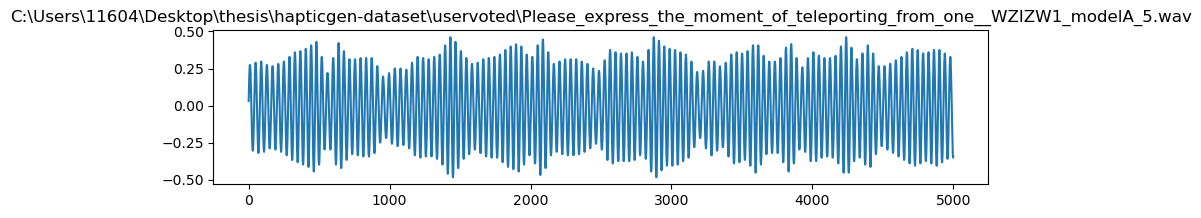

In [3]:
sample_wavs = random.sample(wav_files, 3)

for p in sample_wavs:
    y, sr = librosa.load(p, sr=None, mono=True)
    print("\n---", os.path.basename(p))
    print("sr:", sr, "len:", len(y), "min/max:", float(y.min()), float(y.max()))
    plt.figure(figsize=(10,2))
    plt.plot(y[:5000])
    plt.title(p)
    plt.show()


In [4]:
SR_EXPECT = 8000
T = 4000  # 0.5s @ 8kHz

def load_segment_energy(path, T=T, sr_expect=SR_EXPECT, tries=30, min_energy=5e-4, max_resample=5):
    y, sr = librosa.load(path, sr=None, mono=True)
    if sr != sr_expect:
        y = librosa.resample(y, orig_sr=sr, target_sr=sr_expect)

    if len(y) < T:
        y = np.pad(y, (0, T - len(y)))

    max_start = len(y) - T

    for _ in range(max_resample):
        best_seg = None
        best_energy = -1.0

        for _ in range(tries):
            start = np.random.randint(0, max_start + 1)
            seg = y[start:start+T]
            seg = seg - np.mean(seg)
            e = np.mean(seg**2)
            if e > best_energy:
                best_energy = e
                best_seg = seg

        if best_energy >= min_energy:
            SCALE = 0.25   # ⭐ 关键（0.2~0.5 都可）
            best_seg = best_seg / (GLOBAL_RMS + 1e-6)
            best_seg = best_seg * SCALE
            best_seg = np.clip(best_seg, -3.0, 3.0)
            return best_seg.astype(np.float32)


    # 如果这个 wav 真的是“全程没能量”，最后才返回全 0
    return np.zeros(T, dtype=np.float32)


In [5]:
N = len(wav_files)
perm = np.random.permutation(N)
train_idx = perm[:int(0.8 * N)]
val_idx   = perm[int(0.8 * N):]

train_files = [wav_files[i] for i in train_idx]
val_files   = [wav_files[i] for i in val_idx]

print("train:", len(train_files), "val:", len(val_files))

def estimate_global_rms(files, n=200, sr_expect=SR_EXPECT):
    picks = random.sample(files, min(n, len(files)))
    rms = []
    for p in picks:
        y, sr = librosa.load(p, sr=None, mono=True)
        if sr != sr_expect:
            y = librosa.resample(y, orig_sr=sr, target_sr=sr_expect)
        y = y - np.mean(y)
        rms.append(np.sqrt(np.mean(y**2)) + 1e-8)
    return float(np.median(rms))

GLOBAL_RMS = estimate_global_rms(train_files, n=200)
print("GLOBAL_RMS =", GLOBAL_RMS)

x = load_segment_energy(train_files[0], T=T)
print("seg std:", x.std(), "seg maxabs:", np.max(np.abs(x)))
x2 = load_segment_energy(train_files[1], T=T)
print("seg2 std:", x2.std(), "seg2 maxabs:", np.max(np.abs(x2)))


class HapticWavDataset(Dataset):
    def __init__(self, files, T=4096):
        self.files = files
        self.T = T

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        x = load_segment_energy(self.files[idx], T=self.T)
        return torch.from_numpy(x).unsqueeze(0)


batch_size = 64
train_loader = DataLoader(HapticWavDataset(train_files, T=T), batch_size=batch_size, shuffle=True, drop_last=True)
val_loader   = DataLoader(HapticWavDataset(val_files,   T=T), batch_size=batch_size, shuffle=False, drop_last=False)

# sanity check
xb = next(iter(train_loader))
print("batch shape:", xb.shape)  # (B, 1, T)


train: 2583 val: 646
GLOBAL_RMS = 0.04561787098646164
seg std: 1.6696361 seg maxabs: 2.9773908
seg2 std: 0.49286482 seg2 maxabs: 3.0
batch shape: torch.Size([64, 1, 4000])


In [6]:
xb = next(iter(train_loader))  # (B,1,T)
stds = xb[:,0,:].numpy().std(axis=1)
print("silent-ish ratio:", (stds < 1e-3).mean())
print("std min/median/max:", stds.min(), np.median(stds), stds.max())


silent-ish ratio: 0.046875
std min/median/max: 0.0 0.70600986 2.5251036


In [7]:
class ConvAE(nn.Module):
    def __init__(self, T=4096, latent_dim=64):
        super().__init__()
        self.T = T
        self.latent_dim = latent_dim

        # Encoder: (B,1,T) -> (B,64,T/8)
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=25, stride=2, padding=12),
            # nn.BatchNorm1d(16),
            nn.ReLU(),

            nn.Conv1d(16, 32, kernel_size=9, stride=2, padding=4),
            # nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Conv1d(32, 64, kernel_size=9, stride=2, padding=4),
            # nn.BatchNorm1d(64),
            nn.ReLU(),
        )

        # 计算 encoder 输出长度（随 T 变）
        with torch.no_grad():
            dummy = torch.zeros(1, 1, T)
            h = self.encoder(dummy)
            self.enc_shape = h.shape[1:]             # (C, L)
            self.enc_feat = h.numel()                # C*L

        self.fc_enc = nn.Linear(self.enc_feat, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, self.enc_feat)

        # Decoder: (B,64,L) -> (B,1,T)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(64, 32, kernel_size=9, stride=2, padding=4, output_padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.ConvTranspose1d(32, 16, kernel_size=9, stride=2, padding=4, output_padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),

            nn.ConvTranspose1d(16, 1, kernel_size=9, stride=2, padding=4, output_padding=1),
            # nn.Tanh(),  # 如果你后面发现振幅被压，可以先注释掉
        )

    def forward(self, x):
        h = self.encoder(x)
        h_flat = h.view(h.size(0), -1)
        z = self.fc_enc(h_flat)

        h2 = self.fc_dec(z).view(x.size(0), *self.enc_shape)
        x_hat = self.decoder(h2)

        T = x.shape[-1]
        if x_hat.shape[-1] > T:
            x_hat = x_hat[..., :T]
        elif x_hat.shape[-1] < T:
            x_hat = torch.nn.functional.pad(x_hat, (0, T - x_hat.shape[-1]))
        
        return x_hat, z

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

latent_dim = 64
model = ConvAE(T=T, latent_dim=latent_dim).to(device)

# sanity check shape
with torch.no_grad():
    test_x = torch.randn(4, 1, T).to(device)
    test_hat, test_z = model(test_x)
    print("Input:", test_x.shape, "Output:", test_hat.shape, "Latent:", test_z.shape)


device: cpu
Input: torch.Size([4, 1, 4000]) Output: torch.Size([4, 1, 4000]) Latent: torch.Size([4, 64])


In [8]:
ckpt_path = "conv1d_mse_baseline_best.pt"

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)

total_epochs = 10
print_every = 5
patience = 8
min_delta = 1e-4

train_losses, val_losses = [], []
best_val = float("inf")
best_state = None
wait = 0


In [9]:
def run_epoch(loader, train=True, epoch=1):
    model.train(train)
    total_loss = 0.0
    count = 0

    mode = "train" if train else "val"
    pbar = tqdm(loader, leave=False, desc=f"{mode} epoch {epoch}")

    for x in pbar:
        x = x.to(device)
        if train:
            optimizer.zero_grad()

        x_hat, _ = model(x)
        loss = criterion(x_hat, x)  # ✅ MSE-only baseline

        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        total_loss += loss.item() * x.size(0)
        count += x.size(0)
        pbar.set_postfix(loss=f"{(total_loss/count):.4f}")

    return total_loss / count


for epoch in range(1, total_epochs + 1):
    tr = run_epoch(train_loader, train=True,  epoch=epoch)
    va = run_epoch(val_loader,   train=False, epoch=epoch)

    train_losses.append(tr)
    val_losses.append(va)

    scheduler.step(va)
    lr = optimizer.param_groups[0]["lr"]

    if epoch % print_every == 0 or epoch == 1:
        overall = 100.0 * epoch / total_epochs
        print(f"[Epoch {epoch:03d}/{total_epochs} | overall {overall:5.1f}%] lr={lr:.2e} | train={tr:.6f} | val={va:.6f}")

    # early stopping
    if va < best_val - min_delta:
        best_val = va
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        wait = 0
        torch.save(best_state, ckpt_path)
    else:
        wait += 1
        if wait >= patience:
            print(f"⏹️ Early stopping at epoch {epoch}, best val = {best_val:.6f}")
            break

print("✅ Best val:", best_val)
print("✅ Saved best model weights to:", ckpt_path)

# load best
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.to(device)
model.eval()


[Epoch 001/10 | overall  10.0%] lr=1.00e-03 | train=1.235896 | val=1.136103


[Epoch 005/10 | overall  50.0%] lr=1.00e-03 | train=0.266107 | val=0.251830


[Epoch 010/10 | overall 100.0%] lr=1.00e-03 | train=0.215891 | val=0.237611
✅ Best val: 0.2344442824415009
✅ Saved best model weights to: conv1d_mse_baseline_best.pt


C:\Users\11604\AppData\Local\Temp\ipykernel_42100\4144826629.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=de

ConvAE(
  (encoder): Sequential(
    (0): Conv1d(1, 16, kernel_size=(25,), stride=(2,), padding=(12,))
    (1): ReLU()
    (2): Conv1d(16, 32, kernel_size=(9,), stride=(2,), padding=(4,))
    (3): ReLU()
    (4): Conv1d(32, 64, kernel_size=(9,), stride=(2,), padding=(4,))
    (5): ReLU()
  )
  (fc_enc): Linear(in_features=32000, out_features=64, bias=True)
  (fc_dec): Linear(in_features=64, out_features=32000, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose1d(64, 32, kernel_size=(9,), stride=(2,), padding=(4,), output_padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose1d(32, 16, kernel_size=(9,), stride=(2,), padding=(4,), output_padding=(1,))
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose1d(16, 1, kernel_size=(9,), stride=(2,), padding=(4,), output_padding=(1,))
  )
)

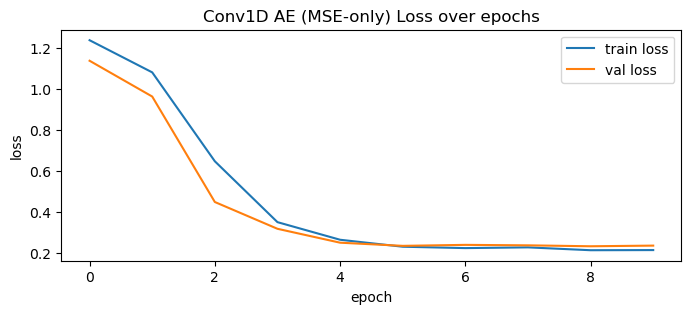

In [10]:
plt.figure(figsize=(8,3))
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.title("Conv1D AE (MSE-only) Loss over epochs")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()


C:\Users\11604\AppData\Local\Temp\ipykernel_42100\3691169571.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=dev

0 orig max 1.6913446 recon max 1.1281582
1 orig max 3.0 recon max 3.5769467
2 orig max 1.1794072 recon max 0.4278738


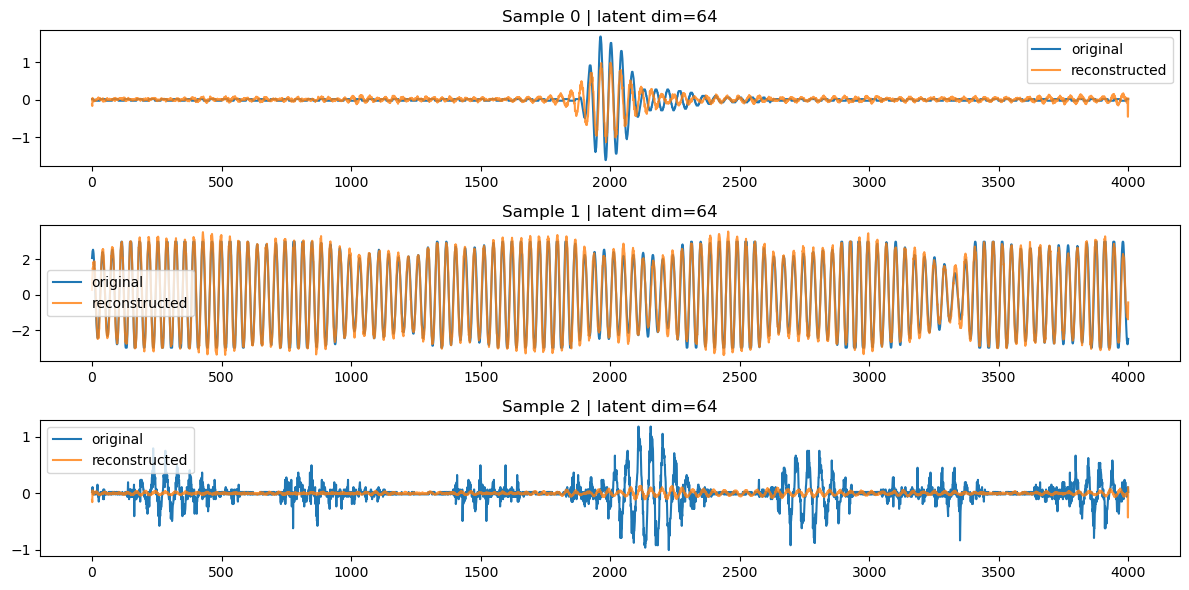

Example latent z[0]: [-0.5529164   0.25242668 -0.32768986 -0.4242316  -1.1701434   0.7820449
  0.8659147  -0.16540256 -0.16406402  1.101699    1.045838    0.8268601
  0.6032898  -0.1125086   0.96792746  0.7514931  -0.6024208  -0.6372274
  0.1621431  -0.64057034 -1.1437379   1.0555094  -0.64662564 -0.4670086
 -1.8831282   0.07607622 -0.16057532  1.6401502  -0.8137756  -0.01545838
  0.26127258 -0.4370282   0.96435434  0.34992275  1.5353051   0.6982955
  0.32718062  0.1381765   2.0240102   0.50397986 -0.12171265 -0.02034332
  0.5210598   0.17022051 -0.2879784   0.5905352   0.88934493 -0.17404412
 -0.2782046   0.69848746  0.17762469 -0.43141887 -2.0883586   0.28582722
  0.07824361 -0.09765037 -1.074475    1.3274658   0.3446803   1.6991091
 -0.9005939  -1.1824731  -0.50157297 -0.23677073]


In [11]:
# 从 val 里拿一批
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

x = next(iter(val_loader))[:3].to(device)  # (3,1,T)

with torch.no_grad():
    x_hat, z = model(x)

x_np = x[:,0,:].cpu().numpy()
xhat_np = x_hat[:,0,:].cpu().numpy()

plt.figure(figsize=(12,6))
for i in range(3):
    print(i, "orig max", np.max(np.abs(x_np[i])), "recon max", np.max(np.abs(xhat_np[i])))
    plt.subplot(3,1,i+1)
    plt.plot(x_np[i], label="original")
    plt.plot(xhat_np[i], label="reconstructed", alpha=0.8)
    plt.title(f"Sample {i} | latent dim={latent_dim}")
    plt.legend()
plt.tight_layout()
plt.show()

print("Example latent z[0]:", z[0].cpu().numpy())


In [30]:
import numpy as np
from IPython.display import Audio, display

sr = SR_EXPECT  # 8000

def prep(w):
    w = w.astype(np.float32)
    # 你现在数据可能在 [-3, 3]，播放前压到 [-1, 1] 防止爆音
    m = np.max(np.abs(w)) + 1e-8
    w = w / m
    return np.clip(w, -1.0, 1.0)

i = 2  # 选第几个样本（0/1/2）

orig = prep(x_np[i])
recon = prep(xhat_np[i])

print("Original:")
display(Audio(orig, rate=sr))

print("Reconstruction:")
display(Audio(recon, rate=sr))

# 拼成一个：原声 -> 0.2s 静音 -> 重建（更方便听差异）
silence = np.zeros(int(0.2 * sr), dtype=np.float32)
ab = np.concatenate([orig, silence, recon])
print("A/B combined:")
display(Audio(ab, rate=sr))


Original:


Reconstruction:


A/B combined:
